In [138]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from autoencoder.modules.model import VAE
from autoencoder.modules.data import MSA_Dataset

## Inspect the pre-processed MSA

In [139]:
MSA_id = "pevae"
data_path = f"msas/independent_sims/processed/10000/{MSA_id}"

## Load data and instantiate dataset

In [140]:
# read in binary representation of MSA
with open(f"{data_path}/msa_leaf_binary.pkl", 'rb') as file_handle:
    msa_binary = torch.tensor(pickle.load(file_handle))
# Number of sequences
n_seq = msa_binary.shape[0]
# Dimensions of one-hot encoding
nl = msa_binary.shape[1]
nc = msa_binary.shape[2]
# Print shape
msa_binary.shape

torch.Size([10000, 100, 20])

In [141]:
# each sequence has a label
with open(f"{data_path}/msa_leaf_keys.pkl", 'rb') as file_handle:
    seq_names = pickle.load(file_handle)
print(len(seq_names))
print(seq_names[:5])

10000
['0', '1', '10', '100', '1000']


In [142]:
# weight equally
seq_weight = np.ones(n_seq) / n_seq
seq_weight = seq_weight.astype(np.float32)

In [143]:
data = MSA_Dataset(msa_binary, seq_weight, seq_names)
# Show a random example
data[5074]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 1e-04,
 '5565')

We see that an item of the dataset contains the one-hot representation of the sequence, the weight assigned to the sequence (explained later), and the name of the sequence

## Instantiate model

In [144]:
# Default num_hidden_units: [256, 256]
model = VAE(nl=nl, nc=nc, dim_latent_vars=2)

Let's check that our model processes data the way we want it to

In [145]:
# Encoding
one_hot_ary = data[100][0]
batch_one_hot_ary = torch.unsqueeze(one_hot_ary, 0)
latent_parameters = model.encoder(batch_one_hot_ary)
print(f"Mean and variance of latent vector:")
print(latent_parameters)
# Decoding
mn_z = latent_parameters[0]
recon_log_probs = model.decoder(mn_z)
print(f"Decoded output has shape {recon_log_probs.shape} and is given by:")
print(recon_log_probs)
probs = torch.exp(recon_log_probs.squeeze())
print("The probability for each amino acid in each position is:")
print(probs)
print("Rows should sum to 1: ")
print(torch.sum(probs, dim=1))

Mean and variance of latent vector:
(tensor([[-0.0135,  0.0103]], grad_fn=<AddmmBackward0>), tensor([[1.0007, 1.0758]], grad_fn=<ExpBackward0>))
Decoded output has shape torch.Size([1, 100, 20]) and is given by:
tensor([[[-2.8837, -3.0095, -3.0493,  ..., -3.0644, -3.0607, -3.0396],
         [-3.0091, -3.0200, -2.9971,  ..., -3.0904, -2.9239, -2.9258],
         [-3.1116, -3.0150, -2.8974,  ..., -3.0553, -2.8900, -3.0127],
         ...,
         [-3.0508, -2.8866, -3.1250,  ..., -2.8543, -3.0273, -3.0078],
         [-2.8749, -3.1760, -2.7966,  ..., -3.0546, -3.0738, -2.9590],
         [-3.0145, -2.9714, -3.0030,  ..., -2.9419, -2.9686, -3.0171]]],
       grad_fn=<LogSoftmaxBackward0>)
The probability for each amino acid in each position is:
tensor([[0.0559, 0.0493, 0.0474,  ..., 0.0467, 0.0469, 0.0479],
        [0.0493, 0.0488, 0.0499,  ..., 0.0455, 0.0537, 0.0536],
        [0.0445, 0.0490, 0.0552,  ..., 0.0471, 0.0556, 0.0492],
        ...,
        [0.0473, 0.0558, 0.0439,  ..., 0.0576,

## Train model

In [ ]:
def train(model, device, train_loader, optimizer, epoch, verbose):
    """
    Define how to do an epoch of training    
    """
    model.train()
    running_elbo = []

    for batch_idx, (msa, weight, _) in enumerate(train_loader):
        msa, weight = msa.to(device), weight.to(device)
        optimizer.zero_grad()
        elbo, _ = model.compute_weighted_elbo(msa, weight)
        loss = (-1)*elbo
        loss.backward()
        optimizer.step()
        elbo_scalar = elbo.item()
        if verbose:
            print("Epoch: {:>4}, Step: {:>4}, loss: {:>4.2f}".format(epoch, batch_idx, elbo_scalar),
                  flush=True)
        running_elbo.append(elbo_scalar)

    return running_elbo

def eval(model, device, valid_loader, n_samples = 1000):
    """
    Define how to do an epoch of evaluation
    """
    model.eval()
    elbos = []
    log_pxgzs = []
    elbo_iwaes = []

    with torch.no_grad():
        for (msa, weight, _) in valid_loader:
            msa = msa.to(device)
            # compute elbo loss with normal elbo
            elbo, log_pxgz = model.compute_weighted_elbo(msa, weight)
            elbos.append(elbo.item())
            log_pxgzs.append(log_pxgz.item())

            # compute elbo loss with iwae elbo
            all_iwae_elbos = model.compute_iwae_elbo(msa, n_samples)
            ave_iwae_elbos = torch.mean(all_iwae_elbos).item()
            elbo_iwaes.append(ave_iwae_elbos)

    return elbos, log_pxgzs, elbo_iwaes

In [155]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Hyperparameters
num_epochs = 10000
wd = 0.01
dim_lat = 2
num_hidden_units = [100]
n_samples = 100
bs = 128
verbose = False

cpu


In [ ]:
# set up data loaders
from sklearn.model_selection import train_test_split
train_idx, test_idx = train_test_split(
    range(len(data)), test_size=0.1, random_state=42)
train_loader = DataLoader(
    data, batch_size=bs, sampler=torch.utils.data.SubsetRandomSampler(train_idx))
valid_loader = DataLoader(
    data, batch_size=bs, sampler=torch.utils.data.SubsetRandomSampler(test_idx))

In [ ]:
model = VAE(nl=nl, nc=nc, dim_latent_vars=dim_lat, num_hidden_units=num_hidden_units).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=wd)

train_elbos = []
val_elbos = []
val_log_pxgzs = []
val_elbo_iwaes = []
for epoch in range(num_epochs):
    # Validation metrics
    # val_elbos_on_batches, val_log_pxgzs_on_batches, val_elbo_iwae_on_batches = eval(
    #     model, device, valid_loader, n_samples)
    # epoch_val_elbo = np.mean(val_elbos_on_batches)
    # epoch_val_log_pxgz = np.mean(val_log_pxgzs_on_batches)
    # epoch_val_elbo_iwae = np.mean(val_elbo_iwae_on_batches)
    # val_elbos.append(epoch_val_elbo)
    # val_log_pxgzs.append(epoch_val_log_pxgz)
    # val_elbo_iwaes.append(epoch_val_elbo_iwae)
    # print(f"Validation elbo for epoch {epoch}: {epoch_val_elbo}")
    # Training metrics
    batch_elbos = train(model, device, train_loader, optimizer, epoch, verbose)
    epoch_train_elbo = np.mean(batch_elbos)
    train_elbos.append(epoch_train_elbo)
    print(f"Training elbo for epoch {epoch}: {epoch_train_elbo}")

In [160]:
# Save model
from datetime import date
import os
os.makedirs(f"saved_models/{MSA_id}", exist_ok=True)
model.cpu()
today = date.today()
layers = "-".join([str(l) for l in num_hidden_units])
torch.save(model.state_dict(
), f"saved_models/independent_sims/10000/{MSA_id}/model_layers{layers}_ld{dim_lat}_wd{wd}_epoch{num_epochs}_{today}.pt")

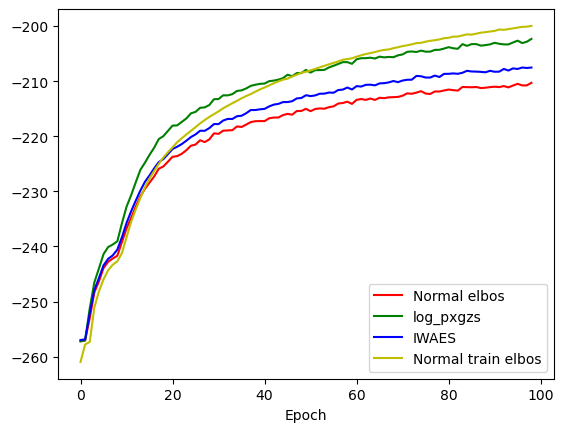

In [153]:
plt.plot(val_elbos[1:], label="Validation elbos", color='r')
plt.plot(val_log_pxgzs[1:], label="Validation log reconstruction probs", color='g')
plt.plot(val_elbo_iwaes[1:], label="Validation IWAE elbos", color='b')
plt.plot(train_elbos[:-1], label="Training elbos", color='y')
plt.xlabel("Epoch")
plt.legend()